In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from matplotlib import pyplot as plt
from IPython.display import clear_output
from matplotlib.colors import TABLEAU_COLORS

sys.path.append('..')
from notebook_utils import Data, train, run_study, load, test_vanilla, test_uncertain

sys.path.append('../../..')
from uncertain.pointwise_ranking.MF import MF
from uncertain.pointwise_ranking.neural import MLP, MCDropout, Ensemble, ItemSupport, UserSupport
from uncertain.pointwise_ranking.bayesianMLP import BayesianMLP

if os.path.isfile('data.pkl'):
    with open('data.pkl', 'rb') as f:
        data = pickle.load(f)
    print(f'MovieLens data loaded: {data.n_user} users, {data.n_item} items.')
    print(f'{len(data.train)} train, {len(data.val)} validation and {len(data.test)} test interactions.')
else:
    data = pd.read_csv('data.csv')
    data.columns = ['user', 'item', 'score', 'timestamps']
    data = Data(data.drop(columns='timestamps'))
    with open('data.pkl', 'wb') as f:
        pickle.dump(data, f, protocol=4)

data.item_support[data.item_support == 0] = 1
data.item_support = data.item_support.astype(float)
data.user_support = data.user_support.astype(float)

trials = 0 ## 0 for eval only mode

MovieLens data loaded: 6040 users, 3416 items.
644083 train, 158002 validation and 197526 test interactions.


# MF

In [2]:
name = 'MF'
def init_model(**kwargs):
    return MF(data.n_user, data.n_item, **kwargs)
base_conf = {'embedding_dim': 10, 'lr': 0, 'weight_decay': 0, 'n_negatives': 0}

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 256, 256)
    params = {'embedding_dim': trial.suggest_int('dim', 128, 128),
              'lr': trial.suggest_float('lr', 1e-4, 1e-2),
              'weight_decay': trial.suggest_float('wd', 1e-6, 1e-4),
              'n_negatives': trial.suggest_int('neg', 1, 20)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
mf = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_vanilla(mf, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
best_runs

[0.4504967  0.5360927  0.5579056  0.56053627 0.5581779  0.5505899
 0.5441366  0.53689295 0.530784   0.52454597]


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_neg,params_wd,user_attrs_filename,state
11,11,0.396343,2022-09-24 03:00:58.305737,2022-09-24 03:11:27.451507,0 days 00:10:29.145770,258,128,0.000311,20,0.000050,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
14,14,0.396322,2022-09-24 03:23:32.012425,2022-09-24 03:36:38.548551,0 days 00:13:06.536126,258,128,0.000199,20,0.000064,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
12,12,0.393977,2022-09-24 03:11:27.452238,2022-09-24 03:19:50.729171,0 days 00:08:23.276933,258,128,0.000287,20,0.000033,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
7,7,0.389016,2022-09-24 02:38:56.259549,2022-09-24 02:44:00.921784,0 days 00:05:04.662235,258,128,0.000683,8,0.000042,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
18,18,0.384651,2022-09-24 03:48:38.893526,2022-09-24 03:53:14.819132,0 days 00:04:35.925606,258,128,0.001165,15,0.000077,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE


## User support

MF-NUS - Recommending:   0%|          | 0/6040 [00:00<?, ?it/s]

/home/vcoscrato/Documents/RecSys/MF/tests/Pointwise/Movielens/../notebook_utils.py:257: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  metrics['MAP-Uncertainty'][i] = MAP[indexer, -1].mean()


[0.68360275 0.62448752 0.59506744 0.55795777 0.51288772 0.47705746
 0.43622321 0.40536436 0.34232414 0.2963143 ]


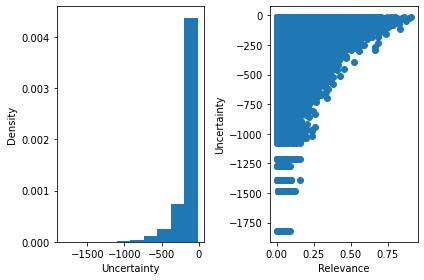

In [3]:
results = test_uncertain(UserSupport(base_MF=mf, uncertainty=-data.user_support), data, name='MF-NUS', max_k=10)
print(results['MAP-Uncertainty'])

## Item support

MF-NIS - Recommending:   0%|          | 0/6040 [00:00<?, ?it/s]

/home/vcoscrato/Documents/RecSys/MF/tests/Pointwise/Movielens/../notebook_utils.py:257: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  metrics['MAP-Uncertainty'][i] = MAP[indexer, -1].mean()


[0.46674177 0.5170154  0.52614689 0.54615617 0.55001497 0.56680006
 0.5673945  0.55360132 0.54844546 0.52096933]


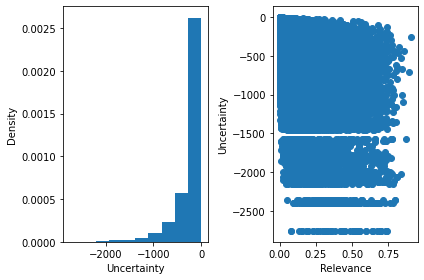

In [4]:
results = test_uncertain(ItemSupport(base_MF=mf, uncertainty=-data.item_support), data, name='MF-NIS', max_k=10)
print(results['MAP-Uncertainty'])

## Ensemble

MF-ENSEMBLE - Recommending:   0%|          | 0/6040 [00:00<?, ?it/s]

/home/vcoscrato/Documents/RecSys/MF/tests/Pointwise/Movielens/../notebook_utils.py:257: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  metrics['MAP-Uncertainty'][i] = MAP[indexer, -1].mean()


[0.46903974 0.55215234 0.57161975 0.5764717  0.5727483  0.56685907
 0.5579156  0.5515218  0.5443794  0.53680843]


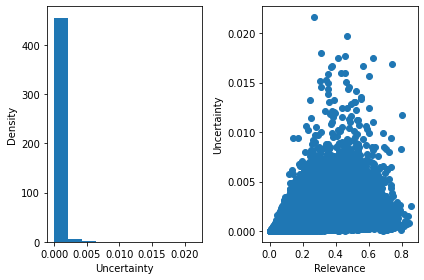

In [5]:
# Load params
best_params = study.best_params
data.batch_size = best_params['bs']
best_params = {'embedding_dim': best_params['dim'], 'lr': best_params['lr'], 
               'n_negatives': best_params['neg'], 'weight_decay': best_params['wd']}

# Train
if trials > 0:
    for i in range(4):
        model = init_model(**best_params)
        train(model, data, path='checkpoints/ensemble_MF', name=f'{i}')

# Load ensemble models
models = [mf]
for file in os.listdir('checkpoints/ensemble_MF'):
    models.append(init_model(**base_conf))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/ensemble_MF', file))
    models[-1].eval()
ensemble = Ensemble(models)
clear_output(wait=True)
results = test_uncertain(ensemble, data, name='MF-ENSEMBLE', max_k=10)
print(results['MAP'])

# MLP

In [6]:
name = 'MLP'
def init_model(**kwargs):
    return MLP(data.n_user, data.n_item, **kwargs)
base_conf = {'embedding_dim': 10, 'lr': 0, 'n_negatives': 0}

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 256, 256)
    params = {'embedding_dim': trial.suggest_int('dim', 128, 128),
              'lr': trial.suggest_float('lr', 1e-4, 1e-2),
              'n_negatives': trial.suggest_int('neg', 1, 20),
              'dropout': trial.suggest_float('layers', 0, 0.2)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
mlp, runs = load(init_model(**base_conf), study)
results = test_vanilla(mlp, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
runs[:5]

[0.4284768  0.50687087 0.5278008  0.5320916  0.529753   0.5254172
 0.5199946  0.51383257 0.5071722  0.50082403]


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_layers,params_lr,params_neg,user_attrs_filename,state
11,11,0.386041,2022-09-28 15:47:42.776429,2022-09-28 16:00:36.777889,0 days 00:12:54.001460,256,128,0.056735,0.007164,20,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
19,19,0.380872,2022-09-28 17:19:06.179352,2022-09-28 17:32:03.417684,0 days 00:12:57.238332,256,128,0.020402,0.004134,15,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
14,14,0.380136,2022-09-28 16:23:53.581303,2022-09-28 16:37:15.046416,0 days 00:13:21.465113,256,128,0.036294,0.003791,17,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
12,12,0.378293,2022-09-28 16:00:36.778752,2022-09-28 16:10:57.714911,0 days 00:10:20.936159,256,128,0.039284,0.007109,16,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
5,5,0.376850,2022-09-28 14:38:02.401921,2022-09-28 14:46:43.236158,0 days 00:08:40.834237,256,128,0.056895,0.006603,13,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE


## User support

MLP-NUS - Recommending:   0%|          | 0/6040 [00:00<?, ?it/s]

/home/vcoscrato/Documents/RecSys/MF/tests/Pointwise/Movielens/../notebook_utils.py:257: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  metrics['MAP-Uncertainty'][i] = MAP[indexer, -1].mean()


[0.68821895 0.62900978 0.5949806  0.52698588 0.49128383 0.44995415
 0.39667937 0.34801227 0.29970387 0.23620133]


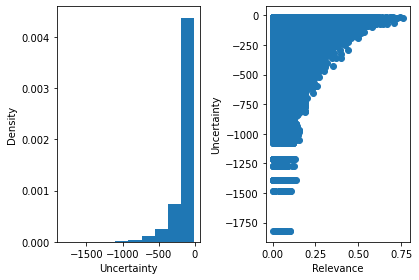

In [7]:
results = test_uncertain(UserSupport(base_MF=mlp, uncertainty=-data.user_support), data, name='MLP-NUS', max_k=10)
print(results['MAP-Uncertainty'])

## Item support

MLP-NIS - Recommending:   0%|          | 0/6040 [00:00<?, ?it/s]

/home/vcoscrato/Documents/RecSys/MF/tests/Pointwise/Movielens/../notebook_utils.py:257: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  metrics['MAP-Uncertainty'][i] = MAP[indexer, -1].mean()


[0.47561702 0.50618756 0.53409231 0.53205895 0.52750593 0.52999198
 0.52456933 0.52434468 0.49704528 0.48521015]


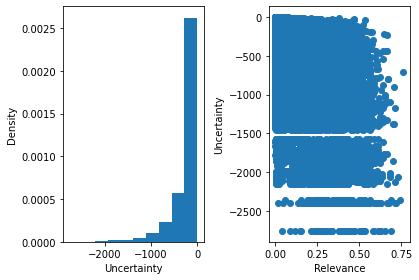

In [8]:
results = test_uncertain(ItemSupport(base_MF=mlp, uncertainty=-data.item_support), data, name='MLP-NIS', max_k=10)
print(results['MAP-Uncertainty'])

## MC Dropout

MCDropout - Recommending:   0%|          | 0/6040 [00:00<?, ?it/s]

/home/vcoscrato/Documents/RecSys/MF/tests/Pointwise/Movielens/../notebook_utils.py:257: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  metrics['MAP-Uncertainty'][i] = MAP[indexer, -1].mean()


[0.40877482 0.48915562 0.5121689  0.5181337  0.51670873 0.51254845
 0.50697064 0.50130874 0.4945478  0.48758432]


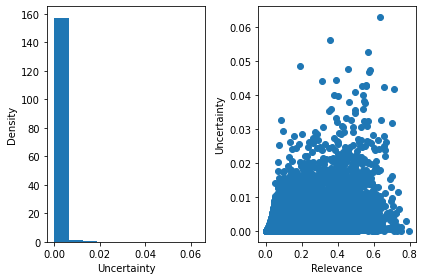

In [9]:
dropout = MCDropout(base_model=mlp, mc_iteration=5)
results = test_uncertain(dropout, data, max_k=10, name='MCDropout')
print(results['MAP'])

## Ensemble

MLP-ENSEMBLE - Recommending:   0%|          | 0/6040 [00:00<?, ?it/s]

/home/vcoscrato/Documents/RecSys/MF/tests/Pointwise/Movielens/../notebook_utils.py:257: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  metrics['MAP-Uncertainty'][i] = MAP[indexer, -1].mean()


[0.48145697 0.5576159  0.5763521  0.57765824 0.5718193  0.56561476
 0.55808884 0.5514747  0.54391736 0.53778523]


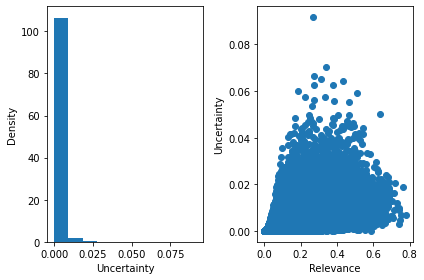

In [10]:
# Load params
best_params = study.best_params
data.batch_size = best_params['bs']
best_params = {'embedding_dim': best_params['dim'], 'lr': best_params['lr'], 
               'n_negatives': best_params['neg'], 'dropout': best_params['layers']}

# Train
if trials > 0:
    for i in range(4):
        model = init_model(**best_params)
        train(model, data, path='checkpoints/ensemble_MLP', name=f'{i}')

# Load ensemble models
models = [mlp]
for file in os.listdir('checkpoints/ensemble_MLP'):
    models.append(init_model(**base_conf))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/ensemble_MLP', file))
    models[-1].eval()
ensemble = Ensemble(models)
clear_output(wait=True)
results = test_uncertain(ensemble, data, name='MLP-ENSEMBLE', max_k=10)
print(results['MAP'])

# BayesianMLP

In [11]:
neg_log_sigma1 = np.array([0, 1, 2])
neg_log_sigma2 = np.array([6, 7, 8])
np.exp(-neg_log_sigma1), np.exp(-neg_log_sigma2)

(array([1.        , 0.36787944, 0.13533528]),
 array([0.00247875, 0.00091188, 0.00033546]))

[0.42168874 0.4967715  0.5188328  0.5243194  0.5233587  0.5186929
 0.5121709  0.5063393  0.5006996  0.49448848]


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_neg,params_pi,params_sigma1,params_sigma2,params_train_samples,user_attrs_filename,state
1,1,0.376164,2022-09-29 00:47:17.339230,2022-09-29 02:17:15.050295,0 days 01:29:57.711065,256,128,0.001445,9,0.75,1.000000,0.000335,3,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
0,0,0.338888,2022-09-28 23:47:33.737253,2022-09-29 00:47:17.338158,0 days 00:59:43.600905,256,128,0.005700,11,0.25,0.367879,0.000912,2,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE


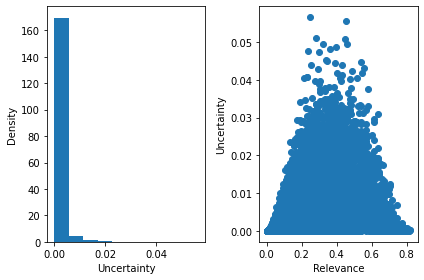

In [12]:
name = 'BayesianMLP'
def init_model(**kwargs):
    return BayesianMLP(data.n_user, data.n_item, **kwargs)
base_conf = {'embedding_dim': 10, 'lr': 0, 'n_negatives': 0, 'num_batches': int(len(data.train) / 256)}

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 256, 256)
    params = {'embedding_dim': trial.suggest_int('dim', 128, 128),
              'lr': trial.suggest_float('lr', 1e-4, 1e-2),
              'n_negatives': trial.suggest_int('neg', 1, 20),
              'sample_train': trial.suggest_int('train_samples', 1, 10),
              'prior_pi': trial.suggest_categorical('pi', [1/4, 1/2, 3/4]),
              'prior_sigma_1': trial.suggest_categorical('sigma1', np.exp(-np.array([0, 1, 2]))),
              'prior_sigma_2': trial.suggest_categorical('sigma2', np.exp(-np.array([6, 7, 8])))}
    params['num_batches'] = int(len(data.train) / 256)
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
BayesMLP, runs = load(init_model(**base_conf), study, top=0)
results = test_uncertain(BayesMLP, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
runs[:5]

# Results

In [21]:
# Load results
results = {}
for key in os.listdir('results'):
    results[key.replace('.pkl', '').replace('_', ' ')] = pickle.load(open(os.path.join('results', key), 'rb'))
order = ['MF', 'MF-NUS', 'MF-NIS', 'MF-ENSEMBLE', 'MLP', 'MLP-NUS', 'MLP-NIS', 'MLP-ENSEMBLE', 'MCDropout', 'BayesianMLP']
results = pd.DataFrame([results[key] for key in order], index=order)

# Plot aestetics
colors = [c for c in list(TABLEAU_COLORS)] + ['k', 'b', 'g', 'r']
colors = {k:c for k, c in zip(results.index, colors)}
lines = ['o', 'v', '^', '<', '>', 's', 'p', '+', 'x', '*']
lines = {k: '-' + l for k, l, in zip(results.index, lines)}

# Results
results[['FCP', 'URI', 'UAC']]

,FCP,URI,UAC
MF,0.866185,NaN,NaN
MF-NUS,0.866185,NaN,-0.466803
MF-NIS,0.866185,0.200632,0.098999
MF-ENSEMBLE,0.868422,0.031700,-0.185691
MLP,0.864828,NaN,NaN
MLP-NUS,0.864828,NaN,-0.523366
MLP-NIS,0.864828,0.147181,0.060190
MLP-ENSEMBLE,0.871819,-0.034607,-0.407960
MCDropout,0.865091,-0.094244,-0.336455
BayesianMLP,0.858191,0.079975,0.134221


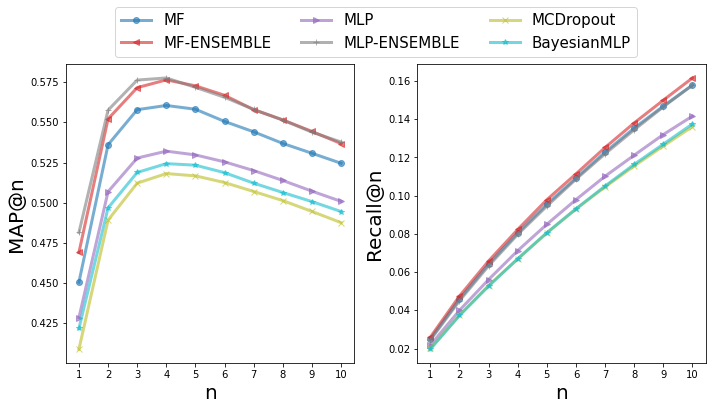

In [23]:
## Top-K accuracy metrics
f, ax = plt.subplots(figsize=(10, 5), ncols=2)
for index, row in results.drop(['MF-NUS', 'MF-NIS', 'MLP-NUS', 'MLP-NIS']).iterrows():
    ax[0].plot(np.arange(1, 11), row['MAP'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
    ax[1].plot(np.arange(1, 11), row['Recall'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('n', fontsize=20)
ax[0].set_ylabel('MAP@n', fontsize=20)
ax[1].set_xticks(np.arange(1, 11))
ax[1].set_xlabel('n', fontsize=20)
ax[1].set_ylabel('Recall@n', fontsize=20)
handles, labels = ax[0].get_legend_handles_labels()
f.legend(handles, labels, fontsize=15, ncol=3, bbox_to_anchor=(0.9, 1.15))
f.tight_layout()
f.savefig('plots/accuracy.pdf')

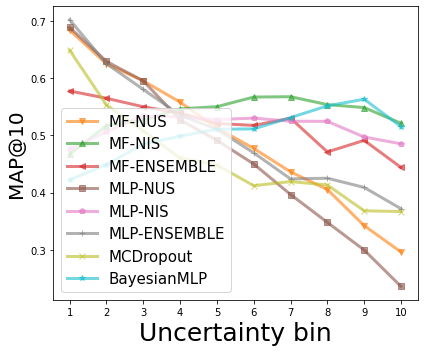

In [24]:
## MAP vs Uncertainty
f, ax = plt.subplots(figsize=(6, 5))
x = np.arange(10) + 1
for index, row in results.drop(['MF', 'MLP']).iterrows():
    ax.plot(x, row['MAP-Uncertainty'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
ax.set(xticks = x)
ax.set_xlabel('Uncertainty bin', fontsize=25)
ax.set_ylabel('MAP@10', fontsize=20)
ax.legend(fontsize=15)
f.tight_layout()
f.savefig('plots/MAP-Uncertainty.pdf')

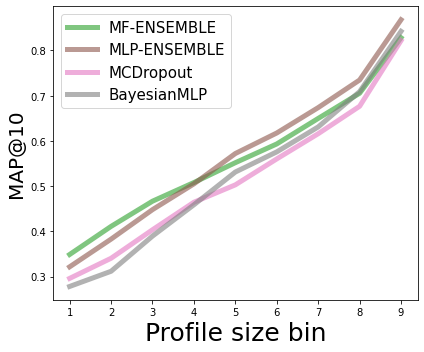

In [13]:
## MAP vs Profile size
f, ax = plt.subplots(figsize=(6, 5))
for index, row in results.drop(['MF', 'MLP', 'MF-NIS', 'MLP-NIS']).iterrows():
    ax.plot(x, row['MAP-ProfSize'], '-', color=colors[index], label=index, linewidth=5, alpha=0.6)
ax.set(xticks = x)
ax.set_xlabel('Profile size bin', fontsize=25)
ax.set_ylabel('MAP@10', fontsize=20)
ax.legend(fontsize=15)
f.tight_layout()
f.savefig('plots/MAP-ProfSize.pdf')

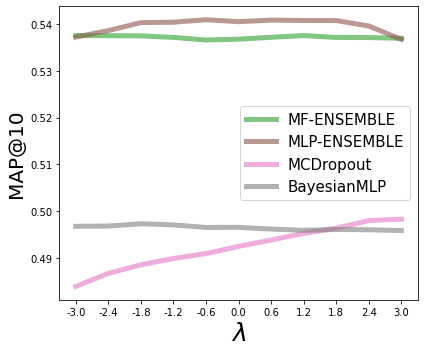

In [14]:
## MAP vs Coverage
f, ax = plt.subplots(figsize=(6, 5))
x = np.linspace(-3, 3, 11)
for index, row in results.drop(['MF', 'MLP', 'MF-NIS', 'MLP-NIS']).iterrows():
    ax.plot(x, row['unc_MAP'], '-', color=colors[index], label=index, linewidth=5, alpha=0.6)
ax.set(xticks = x, xticklabels = [str(round(x, 1)) for x in x])
ax.set_xlabel(r'$\lambda$', fontsize=25)
ax.set_ylabel('MAP@10', fontsize=20)
ax.legend(fontsize=15)
f.tight_layout()
f.savefig('plots/accuracy_lambda.pdf')

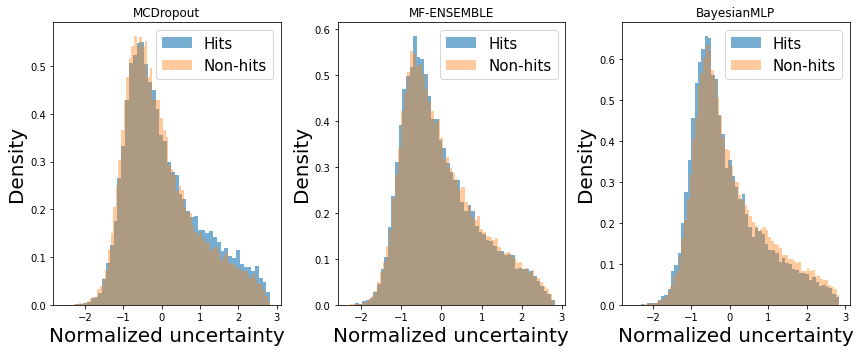

In [15]:
idx = ['MCDropout', 'MF-ENSEMBLE', 'BayesianMLP']
f, ax = plt.subplots(figsize=(12, 5), ncols=len(idx))
for i, model in enumerate(idx):
    ax[i].hist(results.loc[model]['norm_unc'][0], bins='auto', alpha=0.6, density=True, label='Hits')
    ax[i].hist(results.loc[model]['norm_unc'][1], bins='auto', alpha=0.4, density=True, label='Non-hits')
    ax[i].legend(fontsize=15)
    ax[i].set_xlabel('Normalized uncertainty', fontsize=20)
    ax[i].set_ylabel('Density', fontsize=20)
    ax[i].set_title(model)
f.tight_layout()
f.savefig('plots/normalized_uncertainty.pdf')